<h1 id="tocheading">Table of Contents and Notebook Setup</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.dates as mdates
import pandas as pd
import scipy as sp
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy import stats
from datetime import timedelta, datetime
import sympy as smp
from IPython.display import display, Math
smp.init_printing()
%matplotlib inline

In [3]:
dates = ['jan_14_2019', 'jan_15_2019']

In [4]:
ratio_mean_guess = 0.78
ratio_std_guess = 0.02

# Open DataFrames

In [5]:
upper_int = 100000
lower_int = 0

## Pulse Data

Open up all runs.

In [6]:
dfs = []
paths = ['datafiles/'+date for date in dates]
for path in paths:
    for filename in os.listdir(path):
        if filename.endswith(".csv"):
            df = pd.read_csv(path+'/'+filename, sep=',', index_col=0).astype(float)
            df['ratio']=df['Integral 1200']/df['Integral 7400']
            df.index = pd.to_datetime(df.index,unit='s')-timedelta(hours=7)
        
            df = df[(df['ratio']<1) & (df['ratio']>0)] #should not have to do this
            df = df[(df['Integral 7400']<upper_int) & (df['Integral 7400']>lower_int)] #should not have to do this
            dfs.append(df)

dfs = sorted(dfs,key=lambda x:x.index[0]) #sort by initial time

Get beginning and end of each run. Need to subtract 1 hour because computer did not account for the time change.

In [7]:
begins = sorted([df.index.values[0]-np.timedelta64(1,'h') for df in dfs])
ends = sorted([df.index.values[-1]-np.timedelta64(1,'h') for df in dfs])

## Temperature Data

In [8]:
temps = []
for path in paths:
    for filename in os.listdir(path):
        if filename.endswith(".txt"):
            temp = pd.read_csv(path+'/'+filename, skiprows=7, sep='\t')
            temp['Time'] = pd.to_datetime(temp['DATE']+'-'+temp['TIME'])
            temp.index = temp['Time']
            temp = temp[['TEMPERATURE', 'RELATIVE-HUMIDITY', 'DEW-POINT']]
            temps.append(temp)
temps = sorted(temps,key=lambda x:x.index[0]) #sort by initial time

# Fitting Methods to Find the Mode

In [9]:
df = dfs[0]

Define the normal curve:

In [10]:
def norm(x, u, sig, amp):
    return amp*np.exp(-((x-u)**2)/(2*sig**2))

Fit the histogram data between 0.75 and 0.8.

In [11]:
mask = (df['ratio']>0.75) & (df['ratio']<0.825)

h, x , _ = plt.hist(df['ratio'][mask], bins=25); plt.close()
x = x[:-1]

p0  = (ratio_mean_guess, ratio_std_guess, np.max(h))
popt, pcov = curve_fit(norm, x, h, p0=p0)
perr = np.sqrt(np.diag(pcov))

Initial Plot.

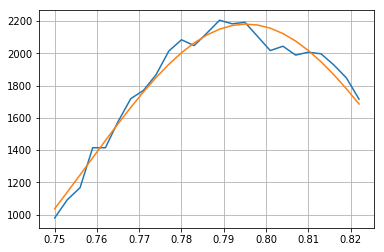

In [12]:
fig, ax = plt.subplots()

ax.plot(x,h)
ax.plot(x,norm(x, popt[0], popt[1], popt[2]), label='Fit')

#ax.set_ylim(0, 400)
ax.grid()

Do plotting:

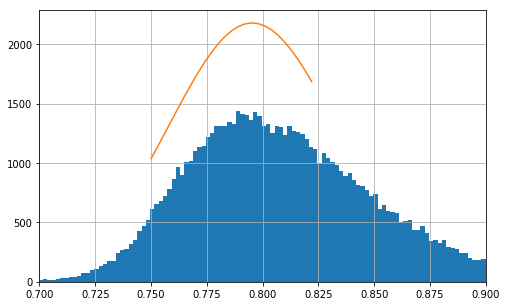

In [13]:
fig, ax = plt.subplots(figsize=(8,5))

y= df['ratio'].hist(bins=500, ax=ax)
ax.plot(x,norm(x, popt[0], popt[1], popt[2]), label='Fit')

ax.set_xlim(0.7,0.9)
plt.show()

## Automation

Now we fit the curve for all histograms. Rather than showing the fitted curve with the histogram, we show the mean and standard deviation as bars.

In [14]:
def mode_ratio(df):
    mask = (df['ratio']>0.75) & (df['ratio']<0.825)

    h, x , _ = plt.hist(df['ratio'][mask], bins=25); plt.close()
    x = x[:-1]

    p0  = (ratio_mean_guess, ratio_std_guess, np.max(h))
    popt, pcov = curve_fit(norm, x, h, p0=p0)
    perr = np.sqrt(np.diag(pcov))
    
    return popt, perr

# Temperature Stuff

## Find Mean and STD Temperature During each of the Red Bars

Now we take the mean and standard deviation of the temperature values per data run. These will be used as data points in the final plot "mean energy ratio as a function of temperature."

In [15]:
all_temps = pd.concat(temps)

def compute_datapoint(df):
    begin = df.index.values[0]-np.timedelta64(1,'h')
    end = df.index.values[-1]-np.timedelta64(1,'h')
    
    temp_mean = all_temps[(all_temps.index>begin)&(all_temps.index<end)]['TEMPERATURE'].mean()
    temp_err = all_temps[(all_temps.index>begin)&(all_temps.index<end)]['TEMPERATURE'].std()
    
    ratio = mode_ratio(df)[0][0]
    ratio_err = mode_ratio(df)[1][0]
    
    return [[temp_mean, ratio], [temp_err, ratio_err]]

Get the data and the errors.

In [56]:
data = [compute_datapoint(df) for df in dfs]

temps = np.array([data[i][0][0] for i in range(len(data))])
ratios = np.array([data[i][0][1] for i in range(len(data))])
temps_err =np.array([data[i][1][0] for i in range(len(data))])
ratios_err =np.array([data[i][1][1] for i in range(len(data))])

lin_minmax = np.array([min(temps), max(temps)])

Do a linear fit on the data, with errors at 95% confidence

In [57]:
def func(x, a, b):
    return a+b*x

[a, b], pcov = curve_fit(func, temps, ratios)
perr = np.sqrt(np.diag(pcov))
[del_a, del_b] = sp.stats.t.ppf(1-0.05/2, len(temps)-2)*perr

lin_fit = a+b*lin_minmax
lin_fit_upr = (a-del_a)+(b+del_b)*lin_minmax
lin_fit_lwr = (a+del_a)+(b-del_b)*lin_minmax

Sample final plot...

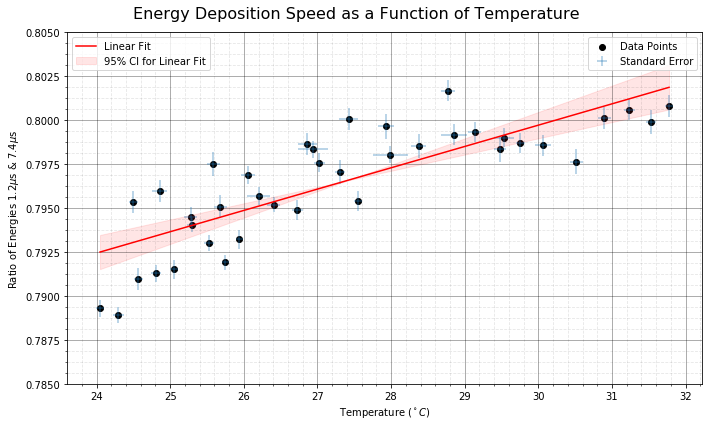

In [58]:
fig, ax = plt.subplots(figsize=(10,6))

#Data
plt_d = ax.scatter(temps, ratios, color='k', label='Data Points')
plt_de = ax.errorbar(temps, ratios, xerr=temps_err, yerr=ratios_err, linestyle='', alpha=0.4, label='Standard Error')

#Fitting
plt_lf, = ax.plot(lin_minmax, lin_fit, color='r', label='Linear Fit')
plt_lfe = ax.fill_between(lin_minmax, lin_fit_lwr, lin_fit_upr, color='r', alpha=0.1, label='95% CI for Linear Fit')

#Other
ax.set_ylim(0.785, 0.805)

ax.set_xlabel('Temperature ($^\circ C$)')
ax.set_ylabel('Ratio of Energies 1.2$\mu$s & 7.4$\mu$s')
fig.suptitle('Energy Deposition Speed as a Function of Temperature', fontsize=16)

plt.minorticks_on()
ax.grid(b=True, which='major', color='k', linestyle='-', alpha=0.4)
ax.grid(b=True, which='minor', color='k', linestyle='--', alpha=0.1)

#Legends
first_legend = plt.legend(handles=[plt_d, plt_de], loc=1)
second_legend = plt.legend(handles=[plt_lf, plt_lfe], loc=2)
ax = plt.gca().add_artist(first_legend)

fig.tight_layout()
fig.subplots_adjust(top=0.92)
plt.savefig('plots/sample_final_plot.png', dpi=600)
plt.show()
